In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed.')

from IPython.display import display, Latex

import nghxrg as ng

In [2]:
# Enable inline plotting
%matplotlib inline
# I prefer the image display origin in the lower left
matplotlib.rcParams['image.origin'] = 'lower'

In [3]:
# Instantiate a noise generator object for NIRSpec H2RGs. You
# can set verbose=True if you want to see diagnostic information. This
# will take about 20 seconds to execute on a modern laptop computer.
ng_h2rg = ng.HXRGNoise(verbose=True, naxis3=2, wind_mode='STRIPE', naxis2=256)

# Use parameters that generate noise similar to JWST NIRSpec
rd_noise=4*4.0   # White read noise per integration
pedestal=1000.*0   # DC pedestal drift rms
c_pink=4*3.0*0     # Correlated pink noise
u_pink=4*1.0*0     # Uncorrelated pink noise
acn=4*0.5*0        # Correlated ACN
pca0_amp=4*0.2   # Amplitude of PCA zero "picture frame" noise

reference_pixel_noise_ratio = 0.8
ktc_noise = 29*0
bias_offset = 5000
bias_amp = 500

0 256


In [7]:
# Do it
hdu1 = ng_h2rg.mknoise('out.fits', rd_noise=rd_noise, pedestal=pedestal,
                c_pink=c_pink, u_pink=u_pink, acn=acn, pca0_amp=pca0_amp,
                reference_pixel_noise_ratio=reference_pixel_noise_ratio,
                ktc_noise=ktc_noise, bias_offset=bias_offset,bias_amp=bias_amp)
#hdu2 = ng_h2rg.mknoise(rd_noise=rd_noise, pedestal=pedestal,
#                c_pink=c_pink, u_pink=u_pink, acn=acn, pca0_amp=pca0_amp,
#                reference_pixel_noise_ratio=reference_pixel_noise_ratio,
#                ktc_noise=ktc_noise, bias_offset=bias_offset,bias_amp=bias_amp)

NG: Starting mknoise() at DATETIME =  06:46:53.470121
NG: Initializing results cube at DATETIME =  06:46:53.470182
NG: Generating rd_noise at DATETIME =  06:46:53.495969
NG: Adding PCA-zero "picture frame" noise at DATETIME =  06:46:53.556043
NG: Converting to 16-bit unsigned integer at DATETIME =  06:46:53.745407
NG: Writing FITS file at DATETIME =  06:46:53.748408
NG: Exiting mknoise() at DATETIME =  06:46:53.757941


7130


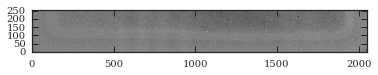

In [10]:
cds1 = hdu1.data[1,:,:] - hdu1.data[0,:,:]
#cds2 = hdu2.data[1,:,:] - hdu2.data[0,:,:]
#plt.imshow(ng_h2rg.c_pink_map[1,:,:]-ng_h2rg.c_pink_map[0,:,:] + 
 #          ng_h2rg.u_pink_map[1,:,:]-ng_h2rg.u_pink_map[0,:,:])
plt.imshow(hdu1.data[0,:,:])
print(np.max(hdu1.data[0,:,:]))

In [19]:
s1 = np.std(ng_h2rg.c_pink_map[1,:,:])
s2 = np.std(ng_h2rg.u_pink_map[1,:,:])
st = np.sqrt(s1**2+s2**2)
print(s1,s2,st)
print(np.std(hdu1.data[1,:,:]))

11.207958468 4.05340586751 11.9184072823
11.8064


In [20]:
def pixmap(header, subarray=False, nf=1, ng=1, nd2=0):

    nx = header['naxis1']
    ny = header['naxis2']
    nz = header['naxis3'] if header['naxis'] == 3 else 1
    nchan = 4; chsize = nx // nchan
    
    pix_rate = 10e-6

    if subarray:
        nchans = 1
        sub = np.array([16.,32,64,128,256,512,1024,2048])
        l1 = np.array([3,2.5,2,2,2,2,2,2])
        l2 = np.array([6,5.0,4,3,2,2,2,2])
        line_add1 = int(np.interp(chsize,sub,l1) + 0.5)
        line_add2 = int(np.interp(chsize,sub,l2) + 0.5)
    else:
        nchans = 4
        line_add1 = 1
        line_add2 = 2

    line_overhead = 12 # 12 pixels per line
    line_time = chsize + line_overhead # Total line time
    pix_offset = nchans // 4 # Single pixel offset for full frame and stripe
    end_delay = 0 # Used for syncing each frame w/ FPE bg activity. May start using soon??

    # Calculate frame times and exposure times for kicks
    frame_time = line_time * ny + line_time * line_add1 + pix_offset + end_delay
    group_time = frame_time * (nf + nd2)
    exp_delay = line_time * (line_add2 - line_add1)
    exp_time = group_time * ng + exp_delay
    
    print(frame_time*10e-6, group_time*10e-6, exp_time*10e-6)

    line = np.arange(chsize) # Number of ticks per line
    map_ch = np.zeros([ny,chsize])
    for i in np.arange(ny):
        map_ch[i,:] = line + i*line_time
        
    map_full = np.zeros([nz,ny,nx])
    for z in np.arange(nz):
        map_full[z,:,:] += frame_time*z
        for op in np.arange(nchan):
            x0 = op * chsize
            x1 = x0 + chsize
            if np.mod(op,2)==0:
                map_full[z,:,x0:x1] += map_ch
            else:
                map_full[z,:,x0:x1] += map_ch[:,::-1]
 

    return map_full*pix_rate

In [22]:
time_arr = pixmap(hdu1.header, nf=1, ng=4, nd2=0)
dim = hdu1.data.shape
nx = dim[2]; ny = dim[1]; nz = dim[0]
nchan = 4; chsize = nx // nchan

1.34669 1.34669 5.392


In [69]:
data = hdu1.data
header = hdu1.header

In [70]:
noise_full = ng_h2rg.c_pink_full

noise_cube = ng_h2rg.c_pink_map
noise_chan0 = noise_cube[:,:,0:chsize]
noise_obs = noise_chan0.flatten()

allnoise_chan0 = data[:,:,0:chsize]
allnoise_chan0 = allnoise_chan0.flatten()

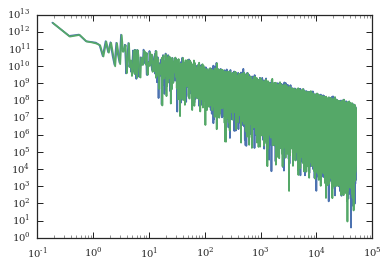

In [71]:
dt = 10e-6
freqs_full = np.fft.rfftfreq(noise_full.size, dt)
noise_full_fft = np.fft.rfft(noise_full)
noise_full_ps = np.abs(noise_full_fft)**2

freqs_obs = np.fft.rfftfreq(noise_obs.size, dt)
noise_obs_fft = np.fft.rfft(noise_obs)
noise_obs_ps = np.abs(noise_obs_fft)**2

freqs_obs = np.fft.rfftfreq(noise_obs.size, dt)
noise_obs_fft = np.fft.rfft(noise_obs)
noise_obs_ps = np.abs(noise_obs_fft)**2


plt.loglog(freqs_full,noise_full_ps)
plt.loglog(freqs_obs,noise_obs_ps)

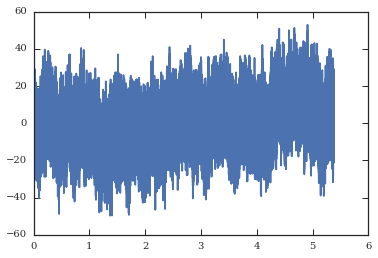

In [29]:
tchan0 = time_arr[:,:,0:chsize]
schan0 = noise_cube[:,:,0:chsize]
plt.plot(tchan0.flatten(),schan0.flatten())

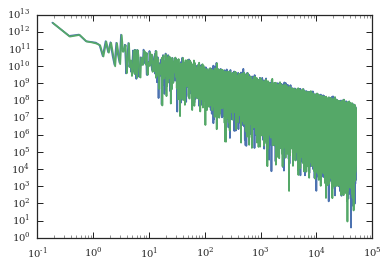

In [31]:
rfreqs_obs = np.fft.rfftfreq(schan0.size, dt)
noise_rfft_obs = np.fft.rfft(schan0.flatten())
noise_rps_obs = np.abs(noise_rfft_obs)**2
plt.loglog(rfreqs,noise_rps)
plt.loglog(rfreqs_obs,noise_rps_obs)